# DML for ATE and LATE of 401(k) on Wealth

## Impact of 401(k) on  Financial Wealth

As a practical illustration of the methods developed in this lecture, we consider estimation of the effect of 401(k) eligibility and participation 
on accumulated assets. 401(k) plans are pension accounts sponsored by employers. The key problem in determining the effect of participation in 401(k) plans on accumulated assets is saver heterogeneity coupled with the fact that the decision to enroll in a 401(k) is non-random. It is generally recognized that some people have a higher preference for saving than others. It also seems likely that those individuals with high unobserved preference for saving would be most likely to choose to participate in tax-advantaged retirement savings plans and would tend to have otherwise high amounts of accumulated assets. The presence of unobserved savings preferences with these properties then implies that conventional estimates that do not account for saver heterogeneity and endogeneity of participation will be biased upward, tending to overstate the savings effects of 401(k) participation.

One can argue that eligibility for enrolling in a 401(k) plan in this data can be taken as exogenous after conditioning on a few observables of which the most important for their argument is income. The basic idea is that, at least around the time 401(k)’s initially became available, people were unlikely to be basing their employment decisions on whether an employer offered a 401(k) but would instead focus on income and other aspects of the job. 

### Data

The data set can be loaded from the `hdm` package for R by typing



In [1]:
install.packages("librarian")
librarian::shelf(
  hdm, ggplot2, 
  , DoubleML
  , mlr3learners
  , mlr3
  , data.table
  , randomForest
  , ranger
  , xgboost
)

library(hdm) 
library(ggplot2)
data(pension)
data <- pension 
dim(data)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘BiocManager’



  These packages will be installed:

  'hdm', 'DoubleML', 'mlr3learners', 'mlr3', 'randomForest',
  'ranger', 'xgboost'

  It may take some time.

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘bbotk’, ‘globals’, ‘listenv’, ‘PRROC’, ‘glmnet’, ‘checkmate’, ‘Formula’, ‘mlr3tuning’, ‘mvtnorm’, ‘clusterGeneration’, ‘readstata13’, ‘mlr3misc’, ‘paradox’, ‘future’, ‘future.apply’, ‘lgr’, ‘mlbench’, ‘mlr3measures’, ‘parallelly’, ‘palmerpenguins’, ‘Rcpp’, ‘RcppEigen’




[1] 9915   44

In [2]:
# save(data, file = "../data/pension.RData")

See the "Details" section on the description of the data set, which can be accessed by 


In [3]:
# help(pension)

The data consist of 9,915 observations at the household level drawn from the 1991 Survey of Income and Program Participation (SIPP).  All the variables are referred to 1990. We use net financial assets (*net\_tfa*) as the outcome variable, $Y$,  in our analysis. The net financial assets are computed as the sum of IRA balances, 401(k) balances, checking accounts, saving bonds, other interest-earning accounts, other interest-earning assets, stocks, and mutual funds less non mortgage debts. 

Among the $9915$ individuals, $3682$ are eligible to participate in the program. The variable *e401* indicates eligibility and *p401* indicates participation, respectively.

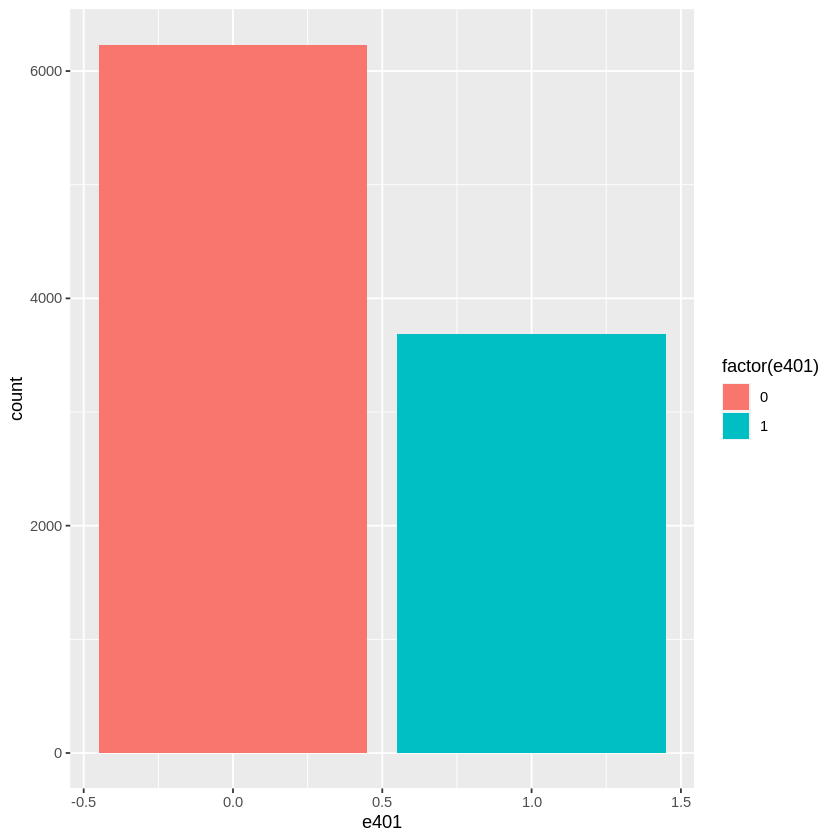

In [4]:
hist_e401 = ggplot(data, aes(x = e401, fill = factor(e401))) + geom_bar()
hist_e401

Eligibility is highly associated with financial wealth:

Warning message:
“Removed 340 rows containing non-finite values (stat_density).”


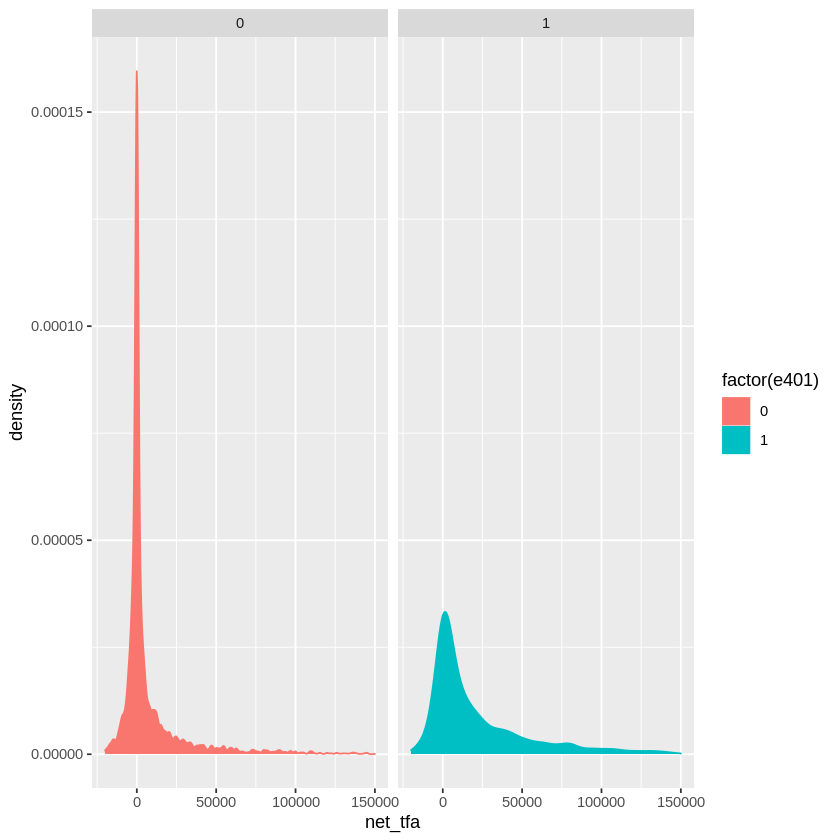

In [5]:
dens_net_tfa = ggplot(data, aes(x = net_tfa, color = factor(e401), fill = factor(e401)) ) + 
                    geom_density() + xlim(c(-20000, 150000)) + 
                    facet_wrap(.~e401) 
                    
dens_net_tfa

The unconditional APE of e401 is about $19559$:

In [6]:
e1 <- data[data$e401==1,]
e0 <- data[data$e401==0,]
round(mean(e1$net_tfa)-mean(e0$net_tfa),0)

[1] 19559

Among the $3682$ individuals that  are eligible, $2594$ decided to participate in the program. The unconditional APE of p401 is about $27372$:

In [7]:
p1 <- data[data$p401==1,]
p0 <- data[data$p401==0,]
round(mean(p1$net_tfa)-mean(p0$net_tfa),0)

[1] 27372

As discussed, these estimates are biased since they do not account for saver heterogeneity and endogeneity of participation.

## Double ML package

We are interested in valid estimators of the average treatment effect of `e401` and `p401` on `net_tfa`. To get those estimators, we use the `DoubleML` package that internally builds on mlr3. You find additional information on the package on the package website https://docs.doubleml.org/ and the R documentation page https://docs.doubleml.org/r/stable/. 

In [8]:
# installing Double ML
#remotes::install_github("DoubleML/doubleml-for-r",quiet=TRUE)


# loading the packages
library(DoubleML)
library(mlr3learners)
library(mlr3)
library(data.table)
library(randomForest)


As mentioned, in the tutorial we use the meta package `mlr3` to generate predictions with machine learning methods. A comprehensive introduction and description of the `mlr3` package is provided in the [mlr3book](https://mlr3book.mlr-org.com/). A list of all learners that you can use in `mlr3` can be found [here](https://mlr3extralearners.mlr-org.com/articles/learners/list_learners.html). The entry in the columns *mlr3 Package* and *Packages* indicate which packages must be installed/loaded in your R session. 

## Estimating the ATE of 401(k) Eligibility on Net Financial Assets

We first look at the treatment effect of e401 on net total financial assets. We give estimates of the ATE and ATT that corresponds to the linear model

\begin{equation*}
Y = D \alpha + f(X)'\beta+ \epsilon,
\end{equation*}

where $f(X)$ includes indicators of marital status, two-earner status, defined benefit pension status, IRA participation status, and home ownership status, and  orthogonal polynomials of degrees 2, 4, 6 and 8 in family size, education, age and  income, respectively. The dimensions of $f(X)$ is 25. 

In the first step, we report estimates of the average treatment effect (ATE) of 401(k) eligibility on net financial assets both in the partially linear regression (PLR) model and in the interactive regression model (IRM) allowing for heterogeneous treatment effects. 


#### Main data

In [9]:
# Constructing the data (as DoubleMLData)
formula_flex = "net_tfa ~ e401 + poly(age, 6, raw=TRUE) + poly(inc, 8, raw=TRUE) + poly(educ, 4, raw=TRUE) + poly(fsize, 2, raw=TRUE) + marr + twoearn + db + pira + hown"
model_flex = as.data.table(model.frame(formula_flex, pension))
x_cols = colnames(model_flex)[-c(1,2)]
data_ml = DoubleMLData$new(model_flex, y_col = "net_tfa", d_cols = "e401", x_cols=x_cols)


p <- dim(model_flex)[2]-2
p

# complex model with two-way interactions
data_interactions = fetch_401k(polynomial_features = TRUE, instrument = FALSE)


[1] 25

#### Auxiliary data

In [10]:
# Constructing the data (as DoubleMLData)
formula_flex = "net_tfa ~ e401 + poly(age, 6, raw=TRUE) + poly(inc, 6, raw=TRUE) + poly(educ, 4, raw=TRUE) + poly(fsize, 2, raw=TRUE) + marr + twoearn + db + pira + hown"
model_flex = as.data.table(model.frame(formula_flex, pension))
x_cols = colnames(model_flex)[-c(1,2)]
data_ml_aux = DoubleMLData$new(model_flex, y_col = "net_tfa", d_cols = "e401", x_cols=x_cols)


## Partially Linear Regression Models (PLR)

We start using lasso to estimate the function $g_0$ and $m_0$ in the following PLR model:

\begin{eqnarray}
 &  Y = D\theta_0 + g_0(X) + \zeta,  &  E[\zeta \mid D,X]= 0,\\
 & D = m_0(X) +  V,   &  E[V \mid X] = 0.
\end{eqnarray}

In [11]:
# Estimating the PLR
lgr::get_logger("mlr3")$set_threshold("warn") 
set.seed(123)
lasso <- lrn("regr.cv_glmnet",nfolds = 5, s = "lambda.min")
lasso_class <- lrn("classif.cv_glmnet", nfolds = 5, s = "lambda.min")

dml_plr <- DoubleMLPLR$new(data_ml_aux, ml_g = lasso, ml_m = lasso_class, n_folds=3)
dml_plr$fit(store_predictions=TRUE)
dml_plr$summary()
lasso_plr <- dml_plr$coef
lasso_std_plr <- dml_plr$se

Warning message:
“The argument ml_g was renamed to ml_l. Please adapt the argument name accordingly. ml_g is redirected to ml_l.
The redirection will be removed in a future version.”


Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
e401      8952       1269   7.057  1.7e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




Let us check the predictive performance of this model.

In [12]:
dml_plr$params_names()
g_hat <- as.matrix(dml_plr$predictions$ml_l) # predictions of g_o
m_hat <- as.matrix(dml_plr$predictions$ml_m) # predictions of m_o

[1] "ml_l" "ml_m"

In [13]:
# cross-fitted RMSE: outcome
y <- as.matrix(pension$net_tfa) # true observations
theta <- as.numeric(dml_plr$coef) # estimated regression coefficient
d <- as.matrix(pension$e401) 
predictions_y <- as.matrix(d*theta)+g_hat # predictions for y
lasso_y_rmse <- sqrt(mean((y-predictions_y)^2)) 
lasso_y_rmse

[1] 53735.74

In [14]:
# cross-fitted RMSE: treatment
d <- as.matrix(pension$e401) 
lasso_d_rmse <- sqrt(mean((d-m_hat)^2)) 
lasso_d_rmse

# cross-fitted ce: treatment
mean(ifelse(m_hat > 0.5, 1, 0) != d)

[1] 0.4443213

[1] 0.3167927

Then, we repeat this procedure for various machine learning methods.

In [15]:
# install.packages( "regr.ranger" )
# install.packages( "classif.ranger" )

In [16]:
# Random Forest
lgr::get_logger("mlr3")$set_threshold("warn") 
randomForest <- lrn("regr.ranger")
randomForest_class <- lrn("classif.ranger")

dml_plr <- DoubleMLPLR$new(data_ml_aux, ml_g = randomForest, ml_m = randomForest_class, n_folds=3)
dml_plr$fit(store_predictions=TRUE) # set store_predictions=TRUE to evaluate the model
dml_plr$summary()
forest_plr <- dml_plr$coef
forest_std_plr <- dml_plr$se

Warning message:
“The argument ml_g was renamed to ml_l. Please adapt the argument name accordingly. ml_g is redirected to ml_l.
The redirection will be removed in a future version.”


Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
e401      8359       1267   6.599 4.14e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




In [17]:
# # Random Forest
# lgr::get_logger("mlr3")$set_threshold("warn") 
# randomForest <- lrn("regr.ranger")
# randomForest_class <- lrn("classif.ranger")

# dml_plr <- DoubleMLPLR$new(data_ml, ml_g = randomForest, ml_m = randomForest_class, n_folds=3)
# dml_plr$fit(store_predictions=TRUE) # set store_predictions=TRUE to evaluate the model
# dml_plr$summary()
# forest_plr <- dml_plr$coef
# forest_std_plr <- dml_plr$se

### data_ml is an environment [info](http://adv-r.had.co.nz/Environments.html)


We can compare the accuracy of this model to the model that has been estimated with lasso.

In [18]:
# Evaluation predictions
g_hat <- as.matrix(dml_plr$predictions$ml_l) # predictions of g_o
m_hat <- as.matrix(dml_plr$predictions$ml_m) # predictions of m_o
theta <- as.numeric(dml_plr$coef) # estimated regression coefficient
predictions_y <- as.matrix(d*theta)+g_hat # predictions for y
forest_y_rmse <- sqrt(mean((y-predictions_y)^2)) 
forest_y_rmse

# cross-fitted RMSE: treatment
forest_d_rmse <- sqrt(mean((d-m_hat)^2)) 
forest_d_rmse

# cross-fitted ce: treatment
mean(ifelse(m_hat > 0.5, 1, 0) != d)

[1] 56078.76

[1] 0.4558187

[1] 0.3324256

In [19]:
library(rpart)

In [20]:
# Trees
lgr::get_logger("mlr3")$set_threshold("warn") 

trees <- lrn("regr.rpart")
trees_class <- lrn("classif.rpart")

dml_plr <- DoubleMLPLR$new(data_ml_aux, ml_l = trees, ml_m = trees_class, n_folds=3)
dml_plr$fit(store_predictions=TRUE)
dml_plr$summary()
tree_plr <- dml_plr$coef
tree_std_plr <- dml_plr$se

# Evaluation predictions
g_hat <- as.matrix(dml_plr$predictions$ml_l) # predictions of g_o
m_hat <- as.matrix(dml_plr$predictions$ml_m) # predictions of m_o
theta <- as.numeric(dml_plr$coef) # estimated regression coefficient
predictions_y <- as.matrix(d*theta)+g_hat # predictions for y
tree_y_rmse <- sqrt(mean((y-predictions_y)^2)) 
tree_y_rmse

# cross-fitted RMSE: treatment
tree_d_rmse <- sqrt(mean((d-m_hat)^2)) 
tree_d_rmse

# cross-fitted ce: treatment
mean(ifelse(m_hat > 0.5, 1, 0) != d)

Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
e401      8835       1317   6.708 1.98e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




[1] 56708.52

[1] 0.4553888

[1] 0.3136662

In [21]:
# Boosting
lgr::get_logger("mlr3")$set_threshold("warn") 
boost<- lrn("regr.xgboost",objective="reg:squarederror")
boost_class <- lrn("classif.xgboost",objective = "binary:logistic",eval_metric ="logloss")

dml_plr <- DoubleMLPLR$new(data_ml_aux, ml_l = boost, ml_m = boost_class, n_folds=3)
dml_plr$fit(store_predictions=TRUE)
dml_plr$summary()
boost_plr <- dml_plr$coef
boost_std_plr <- dml_plr$se

# Evaluation predictions
g_hat <- as.matrix(dml_plr$predictions$ml_l) # predictions of g_o
m_hat <- as.matrix(dml_plr$predictions$ml_m) # predictions of m_o
theta <- as.numeric(dml_plr$coef) # estimated regression coefficient
predictions_y <- as.matrix(d*theta)+g_hat # predictions for y
boost_y_rmse <- sqrt(mean((y-predictions_y)^2)) 
boost_y_rmse

# cross-fitted RMSE: treatment
boost_d_rmse <- sqrt(mean((d-m_hat)^2)) 
boost_d_rmse

# cross-fitted ce: treatment
mean(ifelse(m_hat > 0.5, 1, 0) != d)

Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
e401      8867       1342   6.606 3.95e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




[1] 59816.19

[1] 0.4726804

[1] 0.3237519

Let's sum up the results:

In [22]:
table <- matrix(0, 4, 4)
table[1,1:4]   <- c(lasso_plr,forest_plr,tree_plr,boost_plr)
table[2,1:4]   <- c(lasso_std_plr,forest_std_plr,tree_std_plr,boost_std_plr)
table[3,1:4]   <- c(lasso_y_rmse,forest_y_rmse,tree_y_rmse,boost_y_rmse)
table[4,1:4]   <- c(lasso_d_rmse,forest_d_rmse,tree_d_rmse,boost_d_rmse)
rownames(table) <- c("Estimate","Std.Error","RMSE Y","RMSE D")
colnames(table) <- c("Lasso","Random Forest","Trees","Boosting")
table

,Lasso,Random Forest,Trees,Boosting
Estimate,8.952253e+03,8.359373e+03,8.834641e+03,8.867423e+03
Std.Error,1.268614e+03,1.266746e+03,1.317080e+03,1.342332e+03
RMSE Y,5.373574e+04,5.607876e+04,5.670852e+04,5.981619e+04
RMSE D,4.443213e-01,4.558187e-01,4.553888e-01,4.726804e-01


The best model with lowest RMSE in both equation is the PLR model estimated via lasso. It gives the following estimate:

## Interactive Regression Model (IRM)

Next, we consider estimation of average treatment effects when treatment effects are fully heterogeneous:

 \begin{eqnarray}\label{eq: HetPL1}
 & Y  = g_0(D, X) + U,  &  \quad E[U \mid X, D]= 0,\\
  & D  = m_0(X) + V,  & \quad  E[V\mid X] = 0.
\end{eqnarray}

To reduce the disproportionate impact of extreme propensity score weights in the interactive model
we trim the propensity scores which are close to the bounds.

In [23]:
set.seed(123)
lgr::get_logger("mlr3")$set_threshold("warn") 
dml_irm = DoubleMLIRM$new(data_ml_aux, ml_g = lasso, 
                          ml_m = lasso_class, 
                          trimming_threshold = 0.01, n_folds=3)
dml_irm$fit(store_predictions=TRUE)
dml_irm$summary()
lasso_irm <- dml_irm$coef
lasso_std_irm <- dml_irm$se


# predictions
dml_irm$params_names()
g0_hat <- as.matrix(dml_irm$predictions$ml_g0) # predictions of g_0(D=0, X)
g1_hat <- as.matrix(dml_irm$predictions$ml_g1) # predictions of g_0(D=1, X)
g_hat <- d*g1_hat+(1-d)*g0_hat # predictions of g_0
m_hat <- as.matrix(dml_irm$predictions$ml_m) # predictions of m_o


# cross-fitted RMSE: outcome
y <- as.matrix(pension$net_tfa) # true observations
d <- as.matrix(pension$e401) 
lasso_y_irm <- sqrt(mean((y-g_hat)^2)) 
lasso_y_irm

# cross-fitted RMSE: treatment
lasso_d_irm <- sqrt(mean((d-m_hat)^2)) 
lasso_d_irm

# cross-fitted ce: treatment
mean(ifelse(m_hat > 0.5, 1, 0) != d)

Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
e401      7941       1106   7.177 7.15e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




[1] "ml_g0" "ml_g1" "ml_m"

[1] 55439.51

[1] 0.4440579

[1] 0.3153807

In [24]:
##### forest #####

dml_irm = DoubleMLIRM$new(data_ml_aux, ml_g = randomForest, 
                          ml_m = randomForest_class, 
                          trimming_threshold = 0.01, n_folds=3)
dml_irm$fit(store_predictions=TRUE)
dml_irm$summary()
forest_irm <- dml_irm$coef
forest_std_irm <- dml_plr$se

# predictions
g0_hat <- as.matrix(dml_irm$predictions$ml_g0) # predictions of g_0(D=0, X)
g1_hat <- as.matrix(dml_irm$predictions$ml_g1) # predictions of g_0(D=1, X)
g_hat <- d*g1_hat+(1-d)*g0_hat # predictions of g_0
m_hat <- as.matrix(dml_irm$predictions$ml_m) # predictions of m_o

# cross-fitted RMSE: outcome
y <- as.matrix(pension$net_tfa) # true observations
d <- as.matrix(pension$e401) 
forest_y_irm <- sqrt(mean((y-g_hat)^2)) 
forest_y_irm

# cross-fitted RMSE: treatment
forest_d_irm <- sqrt(mean((d-m_hat)^2)) 
forest_d_irm

# cross-fitted ce: treatment
mean(ifelse(m_hat > 0.5, 1, 0) != d)


Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
e401      7809       1311   5.955  2.6e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




[1] 55502.95

[1] 0.4559869

[1] 0.3290973

In [25]:

##### trees #####

dml_irm <- DoubleMLIRM$new(data_ml_aux, ml_g = trees, ml_m = trees_class, 
                           trimming_threshold = 0.01, n_folds=3)
dml_irm$fit(store_predictions=TRUE)
dml_irm$summary()
tree_irm <- dml_irm$coef
tree_std_irm <- dml_irm$se

# predictions
g0_hat <- as.matrix(dml_irm$predictions$ml_g0) # predictions of g_0(D=0, X)
g1_hat <- as.matrix(dml_irm$predictions$ml_g1) # predictions of g_0(D=1, X)
g_hat <- d*g1_hat+(1-d)*g0_hat # predictions of g_0
m_hat <- as.matrix(dml_irm$predictions$ml_m) # predictions of m_o

# cross-fitted RMSE: outcome
y <- as.matrix(pension$net_tfa) # true observations
d <- as.matrix(pension$e401) 
tree_y_irm <- sqrt(mean((y-g_hat)^2)) 
tree_y_irm

# cross-fitted RMSE: treatment
tree_d_irm <- sqrt(mean((d-m_hat)^2)) 
tree_d_irm

# cross-fitted ce: treatment
mean(ifelse(m_hat > 0.5, 1, 0) != d)

Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
e401      7477       1187     6.3 2.97e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




[1] 57305.26

[1] 0.455894

[1] 0.3135653

In [26]:
##### boosting #####

dml_irm <- DoubleMLIRM$new(data_ml_aux, ml_g = boost, ml_m = boost_class,
                           trimming_threshold = 0.01, n_folds=3)
dml_irm$fit(store_predictions=TRUE)
dml_irm$summary()
boost_irm <- dml_irm$coef
boost_std_irm <- dml_irm$se

# predictions
g0_hat <- as.matrix(dml_irm$predictions$ml_g0) # predictions of g_0(D=0, X)
g1_hat <- as.matrix(dml_irm$predictions$ml_g1) # predictions of g_0(D=1, X)
g_hat <- d*g1_hat+(1-d)*g0_hat # predictions of g_0
m_hat <- as.matrix(dml_irm$predictions$ml_m) # predictions of m_o

# cross-fitted RMSE: outcome
y <- as.matrix(pension$net_tfa) # true observations
d <- as.matrix(pension$e401) 
boost_y_irm <- sqrt(mean((y-g_hat)^2)) 
boost_y_irm

# cross-fitted RMSE: treatment
boost_d_irm <- sqrt(mean((d-m_hat)^2)) 
boost_d_irm

# cross-fitted ce: treatment
mean(ifelse(m_hat > 0.5, 1, 0) != d)

Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
e401      8353       1228   6.803 1.03e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




[1] 61055.91

[1] 0.4732346

[1] 0.3234493

In [27]:
table <- matrix(0, 4, 4)
table[1,1:4]   <- c(lasso_irm,forest_irm,tree_irm,boost_irm)
table[2,1:4]   <- c(lasso_std_irm,forest_std_irm,tree_std_irm,boost_std_irm)
table[3,1:4]   <- c(lasso_y_irm,forest_y_irm,tree_y_irm,boost_y_irm)
table[4,1:4]   <- c(lasso_d_irm,forest_d_irm,tree_d_irm,boost_d_irm)
rownames(table) <- c("Estimate","Std.Error","RMSE Y","RMSE D")
colnames(table) <- c("Lasso","Random Forest","Trees","Boosting")
table

,Lasso,Random Forest,Trees,Boosting
Estimate,7.941055e+03,7.808952e+03,7477.066528,8.353329e+03
Std.Error,1.106525e+03,1.342332e+03,1186.745746,1.227915e+03
RMSE Y,5.543951e+04,5.550295e+04,57305.260965,6.105591e+04
RMSE D,4.440579e-01,4.559869e-01,0.455894,4.732346e-01


Here, Random Forest gives the best prediction rule for $g_0$ and Lasso the best prediction rule for $m_0$, respectively. Let us fit the IRM model using the best ML method for each equation to get a final estimate for the treatment effect of eligibility.

In [28]:
set.seed(123)
lgr::get_logger("mlr3")$set_threshold("warn") 
dml_irm = DoubleMLIRM$new(data_ml_aux, ml_g = randomForest, 
                          ml_m = lasso_class, 
                          trimming_threshold = 0.01, n_folds=3)
dml_irm$fit(store_predictions=TRUE)
dml_irm$summary()
best_irm <- dml_irm$coef
best_std_irm <- dml_irm$se

Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
e401      8286       1118   7.411 1.25e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




These estimates that flexibly account for confounding are
substantially attenuated relative to the baseline estimate (*19559*) that does not account for confounding. They suggest much smaller causal effects of 401(k) eligiblity on financial asset holdings. 

## Local Average Treatment Effects of 401(k) Participation on Net Financial Assets

## Interactive IV Model (IIVM)

Now, we consider estimation of local average treatment effects (LATE) of participation with the binary instrument `e401`. As before, $Y$ denotes the outcome `net_tfa`, and $X$ is the vector of covariates.  Here the structural equation model is:

\begin{eqnarray}
& Y = g_0(Z,X) + U, &\quad E[U\mid Z,X] = 0,\\
& D = r_0(Z,X) + V, &\quad E[V\mid Z, X] = 0,\\
& Z = m_0(X) + \zeta, &\quad E[\zeta \mid X] = 0.
\end{eqnarray}

In [29]:
# # Constructing the data (as DoubleMLData)
# formula_flex2 = "net_tfa ~ p401+ e401 + poly(age, 6, raw=TRUE) + poly(inc, 8, raw=TRUE) + poly(educ, 4, raw=TRUE) + poly(fsize, 2, raw=TRUE) + marr + twoearn + db + pira + hown"
# model_flex2 = as.data.table(model.frame(formula_flex2, data))
# x_cols = colnames(model_flex2)[-c(1,2,3)]
# data_IV = DoubleMLData$new(model_flex2, y_col = "net_tfa", d_cols = "p401", z_cols ="e401",x_cols=x_cols)

In [30]:
# Constructing the data (as DoubleMLData)
formula_flex2 = "net_tfa ~ p401+ e401 + poly(age, 6, raw=TRUE) + poly(inc, 6, raw=TRUE) + poly(educ, 4, raw=TRUE) + poly(fsize, 2, raw=TRUE) + marr + twoearn + db + pira + hown"
model_flex2 = as.data.table(model.frame(formula_flex2, data))
x_cols = colnames(model_flex2)[-c(1,2,3)]
data_IV_aux = DoubleMLData$new(model_flex2, y_col = "net_tfa", d_cols = "p401", z_cols ="e401",x_cols=x_cols)

In [31]:
set.seed(123)
lgr::get_logger("mlr3")$set_threshold("warn") 
dml_MLIIVM = DoubleMLIIVM$new(data_IV_aux, ml_g = lasso, 
                       ml_m = lasso_class, ml_r = lasso_class,n_folds=3, subgroups = list(always_takers = FALSE, 
                                         never_takers = TRUE))
dml_MLIIVM$fit(store_predictions=TRUE)
dml_MLIIVM$summary()
lasso_MLIIVM <- dml_MLIIVM$coef
lasso_std_MLIIVM <- dml_MLIIVM$se

Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
p401     11484       1596   7.195 6.25e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




The confidence interval for the local average treatment effect of participation is given by

In [32]:
dml_MLIIVM$confint(level = 0.95)

,2.5 %,97.5 %
p401,8356.038,14612.92


Here we can also check the accuracy of the model:

In [33]:
# variables
y <- as.matrix(pension$net_tfa) # true observations
d <- as.matrix(pension$p401) 
z <- as.matrix(pension$e401) 

# predictions
dml_MLIIVM$params_names()
g0_hat <- as.matrix(dml_MLIIVM$predictions$ml_g0) # predictions of g_0(z=0, X)
g1_hat <- as.matrix(dml_MLIIVM$predictions$ml_g1) # predictions of g_0(z=1, X)
g_hat <- z*g1_hat+(1-z)*g0_hat # predictions of g_0
r0_hat <- as.matrix(dml_MLIIVM$predictions$ml_r0) # predictions of r_0(z=0, X)
r1_hat <- as.matrix(dml_MLIIVM$predictions$ml_r1) # predictions of r_0(z=1, X)
r_hat <- z*r1_hat+(1-z)*r0_hat # predictions of r_0
m_hat <- as.matrix(dml_MLIIVM$predictions$ml_m) # predictions of m_o

[1] "ml_g0" "ml_g1" "ml_m"  "ml_r0" "ml_r1"

In [34]:
# cross-fitted RMSE: outcome
lasso_y_MLIIVM <- sqrt(mean((y-g_hat)^2)) 
lasso_y_MLIIVM

# cross-fitted RMSE: treatment
lasso_d_MLIIVM <- sqrt(mean((d-r_hat)^2)) 
lasso_d_MLIIVM

# cross-fitted RMSE: instrument
lasso_z_MLIIVM <- sqrt(mean((z-m_hat)^2)) 
lasso_z_MLIIVM


[1] 55439.51

[1] 0.2730651

[1] 0.4440579

Again, we repeat the procedure for the other machine learning methods:

In [35]:
### random forest ###

set.seed(123)
lgr::get_logger("mlr3")$set_threshold("warn") 
dml_MLIIVM = DoubleMLIIVM$new(data_IV_aux, ml_g = randomForest, 
                       ml_m = randomForest_class, ml_r = randomForest_class,n_folds=3, subgroups = list(always_takers = FALSE, 
                                         never_takers = TRUE))
dml_MLIIVM$fit(store_predictions=TRUE)
dml_MLIIVM$summary()
forest_MLIIVM <- dml_MLIIVM$coef
forest_std_MLIIVM <- dml_MLIIVM$se

# predictions
g0_hat <- as.matrix(dml_MLIIVM$predictions$ml_g0) # predictions of g_0(Z=0, X)
g1_hat <- as.matrix(dml_MLIIVM$predictions$ml_g1) # predictions of g_0(Z=1, X)
g_hat <- z*g1_hat+(1-z)*g0_hat # predictions of g_0
r0_hat <- as.matrix(dml_MLIIVM$predictions$ml_r0) # predictions of r_0(Z=0, X)
r1_hat <- as.matrix(dml_MLIIVM$predictions$ml_r1) # predictions of r_0(Z=1, X)
r_hat <- z*r1_hat+(1-z)*r0_hat # predictions of r_0
m_hat <- as.matrix(dml_MLIIVM$predictions$ml_m) # predictions of m_o

# cross-fitted RMSE: outcome
forest_y_MLIIVM <- sqrt(mean((y-g_hat)^2)) 
forest_y_MLIIVM

# cross-fitted RMSE: treatment
forest_d_MLIIVM <- sqrt(mean((d-r_hat)^2)) 
forest_d_MLIIVM

# cross-fitted RMSE: instrument
forest_z_MLIIVM <- sqrt(mean((z-m_hat)^2)) 
forest_z_MLIIVM


Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
p401     12386       1861   6.655 2.84e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




[1] 55894.92

[1] 0.281485

[1] 0.4558207

In [36]:
### trees ###

dml_MLIIVM = DoubleMLIIVM$new(data_IV_aux, ml_g = trees, 
                       ml_m = trees_class, ml_r = trees_class,n_folds=3, subgroups = list(always_takers = FALSE, 
                                         never_takers = TRUE))
dml_MLIIVM$fit(store_predictions=TRUE)
dml_MLIIVM$summary()
tree_MLIIVM <- dml_MLIIVM$coef
tree_std_MLIIVM <- dml_MLIIVM$se

# predictions
g0_hat <- as.matrix(dml_MLIIVM$predictions$ml_g0) # predictions of g_0(Z=0, X)
g1_hat <- as.matrix(dml_MLIIVM$predictions$ml_g1) # predictions of g_0(Z=1, X)
g_hat <- z*g1_hat+(1-z)*g0_hat # predictions of g_0
r0_hat <- as.matrix(dml_MLIIVM$predictions$ml_r0) # predictions of r_0(Z=0, X)
r1_hat <- as.matrix(dml_MLIIVM$predictions$ml_r1) # predictions of r_0(Z=1, X)
r_hat <- z*r1_hat+(1-z)*r0_hat # predictions of r_0
m_hat <- as.matrix(dml_MLIIVM$predictions$ml_m) # predictions of m_o

# cross-fitted RMSE: outcome
tree_y_MLIIVM <- sqrt(mean((y-g_hat)^2)) 
tree_y_MLIIVM

# cross-fitted RMSE: treatment
tree_d_MLIIVM <- sqrt(mean((d-r_hat)^2)) 
tree_d_MLIIVM

# cross-fitted RMSE: instrument
tree_z_MLIIVM <- sqrt(mean((z-m_hat)^2)) 
tree_z_MLIIVM


Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
p401     11341       1719   6.596 4.23e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




[1] 58138.87

[1] 0.2780659

[1] 0.4556836

In [37]:


### boosting ###
dml_MLIIVM = DoubleMLIIVM$new(data_IV_aux, ml_g = boost, 
                       ml_m = boost_class, ml_r = boost_class,n_folds=3, subgroups = list(always_takers = FALSE, 
                                         never_takers = TRUE))
dml_MLIIVM$fit(store_predictions=TRUE)
dml_MLIIVM$summary()
boost_MLIIVM <- dml_MLIIVM$coef
boost_std_MLIIVM <- dml_MLIIVM$se

# predictions
g0_hat <- as.matrix(dml_MLIIVM$predictions$ml_g0) # predictions of g_0(Z=0, X)
g1_hat <- as.matrix(dml_MLIIVM$predictions$ml_g1) # predictions of g_0(Z=1, X)
g_hat <- z*g1_hat+(1-z)*g0_hat # predictions of g_0
r0_hat <- as.matrix(dml_MLIIVM$predictions$ml_r0) # predictions of r_0(Z=0, X)
r1_hat <- as.matrix(dml_MLIIVM$predictions$ml_r1) # predictions of r_0(Z=1, X)
r_hat <- z*r1_hat+(1-z)*r0_hat # predictions of r_0
m_hat <- as.matrix(dml_MLIIVM$predictions$ml_m) # predictions of m_o

# cross-fitted RMSE: outcome
boost_y_MLIIVM <- sqrt(mean((y-g_hat)^2)) 
boost_y_MLIIVM

# cross-fitted RMSE: treatment
boost_d_MLIIVM <- sqrt(mean((d-r_hat)^2)) 
boost_d_MLIIVM

# cross-fitted RMSE: instrument
boost_z_MLIIVM <- sqrt(mean((z-m_hat)^2)) 
boost_z_MLIIVM

Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
p401     12529       1822   6.878 6.08e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




[1] 61377.34

[1] 0.2897971

[1] 0.4726815

In [38]:
# library(xtable)
table <- matrix(0, 5, 4)
table[1,1:4]   <- c(lasso_MLIIVM,forest_MLIIVM,tree_MLIIVM,boost_MLIIVM)
table[2,1:4]   <- c(lasso_std_MLIIVM,forest_std_MLIIVM,tree_std_MLIIVM,boost_std_MLIIVM)
table[3,1:4]   <- c(lasso_y_MLIIVM,forest_y_MLIIVM,tree_y_MLIIVM,boost_y_MLIIVM)
table[4,1:4]   <- c(lasso_d_MLIIVM,forest_d_MLIIVM,tree_d_MLIIVM,boost_d_MLIIVM)
table[5,1:4]   <- c(lasso_z_MLIIVM,forest_z_MLIIVM,tree_z_MLIIVM,boost_z_MLIIVM)
rownames(table) <- c("Estimate","Std.Error","RMSE Y","RMSE D","RMSE Z")
colnames(table) <- c("Lasso","Random Forest","Trees","Boosting")
# tab<- xtable(table, digits = 2)
table

,Lasso,Random Forest,Trees,Boosting
Estimate,1.148448e+04,1.238592e+04,1.134090e+04,1.252911e+04
Std.Error,1.596173e+03,1.861187e+03,1.719411e+03,1.821686e+03
RMSE Y,5.543951e+04,5.589492e+04,5.813887e+04,6.137734e+04
RMSE D,2.730651e-01,2.814850e-01,2.780659e-01,2.897971e-01
RMSE Z,4.440579e-01,4.558207e-01,4.556836e-01,4.726815e-01


We report results based on four ML methods for estimating the nuisance functions used in
forming the orthogonal estimating equations. We find again that the estimates of the treatment effect are stable across ML methods. The estimates are highly significant, hence we would reject the hypothesis
that the effect of 401(k) participation has no effect on financial health.

We might rerun the model using the best ML method for each equation to get a final estimate for the treatment effect of participation:

In [39]:
set.seed(123)
lgr::get_logger("mlr3")$set_threshold("warn") 
dml_MLIIVM = DoubleMLIIVM$new(data_IV_aux, ml_g = randomForest, 
                       ml_m = lasso_class, ml_r = lasso_class,n_folds=3, subgroups = list(always_takers = FALSE, 
                                         never_takers = TRUE))
dml_MLIIVM$fit(store_predictions=TRUE)
dml_MLIIVM$summary()
best_MLIIVM <- dml_MLIIVM$coef
best_std_MLIIVM <- dml_MLIIVM$se

Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
p401     11984       1612   7.433 1.06e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


